In [2]:
import matplotlib.pyplot as plt
import matplotlib
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import cartopy

<img src="https://www.roc.noaa.gov/wsr88d/Images/USACoverageBoB10kFt.png" width="1600">

In [3]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [4]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

/Users/chowdahead/miniconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/chowdahead/miniconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [7]:
station = "KFTG"

In [8]:
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
query = rs.query()
now = datetime(2019,3,3,18,0)
query.stations(station).time(now) #datetime.utcnow()
rs.validate_query(query)
catalog = rs.get_catalog(query)
station = str(catalog.datasets[0])
station = station[0:4]
station
ds = list(catalog.datasets.values())[0]
ds.access_urls
data = Dataset(ds.access_urls['CdmRemote'])
print(data.time_coverage_start)
time_stamp = data.time_coverage_start[:10].replace("-","_")+"_"+data.time_coverage_start[11:16].replace(":","")+"Z"
time_stamp
sweep = 0
ref_var = data.variables['Reflectivity_HI']

2019-03-03T18:01:19Z


In [9]:
list(data.variables)

['Reflectivity_HI',
 'timeR_HI',
 'elevationR_HI',
 'azimuthR_HI',
 'distanceR_HI',
 'numRadialsR_HI',
 'numGatesR_HI',
 'Reflectivity',
 'timeR',
 'elevationR',
 'azimuthR',
 'distanceR',
 'numRadialsR',
 'numGatesR',
 'RadialVelocity_HI',
 'timeV_HI',
 'elevationV_HI',
 'azimuthV_HI',
 'distanceV_HI',
 'numRadialsV_HI',
 'numGatesV_HI',
 'RadialVelocity',
 'timeV',
 'elevationV',
 'azimuthV',
 'distanceV',
 'numRadialsV',
 'numGatesV',
 'SpectrumWidth_HI',
 'SpectrumWidth',
 'DifferentialReflectivity_HI',
 'timeD_HI',
 'elevationD_HI',
 'azimuthD_HI',
 'distanceD_HI',
 'numRadialsD_HI',
 'numGatesD_HI',
 'DifferentialReflectivity',
 'timeD',
 'elevationD',
 'azimuthD',
 'distanceD',
 'numRadialsD',
 'numGatesD',
 'CorrelationCoefficient_HI',
 'timeC_HI',
 'elevationC_HI',
 'azimuthC_HI',
 'distanceC_HI',
 'numRadialsC_HI',
 'numGatesC_HI',
 'CorrelationCoefficient',
 'timeC',
 'elevationC',
 'azimuthC',
 'distanceC',
 'numRadialsC',
 'numGatesC',
 'DifferentialPhase_HI',
 'timeP_HI',

In [ ]:
query = rs.query()
dt = datetime(2019, 4, 25, 17) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

In [ ]:
cat = rs.get_catalog(query)
cat.datasets

In [17]:
def Map(station,Year,Month,Day,Hour,Min):    
    ref_norm, ref_cmap = ctables.registry.get_with_range('NWS8bitVel', -110, 110)
    rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
    query = rs.query()
    now = datetime(Year,Month,Day,Hour,Min)
    query.stations(station).time(now) #datetime.utcnow()
    rs.validate_query(query)
    catalog = rs.get_catalog(query)
    station = str(catalog.datasets[0])
    station = station[0:4]
    station
    ds = list(catalog.datasets.values())[0]
    ds.access_urls
    data = Dataset(ds.access_urls['CdmRemote'])
    print(data.time_coverage_start)
    time_stamp = data.time_coverage_start[:10].replace("-","_")+"_"+data.time_coverage_start[11:16].replace(":","")+"Z"
    time_stamp
    sweep = 0
    #ref_var = data.variables['Reflectivity_HI']
    ref_var = data.variables['RadialVelocity_HI']
    ref_data = ref_var[sweep]
    #rng = data.variables['distanceR_HI'][:]
    #az = data.variables['azimuthR_HI'][sweep]
    rng = data.variables['distanceV_HI'][:]
    az = data.variables['azimuthV_HI'][sweep]
    ref = raw_to_masked_float(ref_var, ref_data)
    x, y = polar_to_cartesian(az, rng)
    #ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

    fig = plt.figure(figsize=(10, 10))
     # Create projection centered on the radar. This allows us to use x
        # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=data.StationLongitude, central_latitude=data.StationLatitude)

        # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

        # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

        # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
            category='cultural', name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    radar = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    
    # Colorbar Axis Placement (under figure)
    colorbar_axis = [0.218, 0.01, 0.589, 0.03] # [left, bottom, width, height]

    cbaxes = fig.add_axes(colorbar_axis) # [left, bottom, width, height]

    cbar = plt.colorbar(radar, orientation='horizontal',cax=cbaxes)
    plt.savefig("/Users/chowdahead/Desktop/"+station+"_RADAR_"+time_stamp+".png",bbox_inches="tight")
    #ax = new_map(fig, data.StationLongitude, data.StationLatitude)
    #ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
   

2019-05-27T19:32:50Z


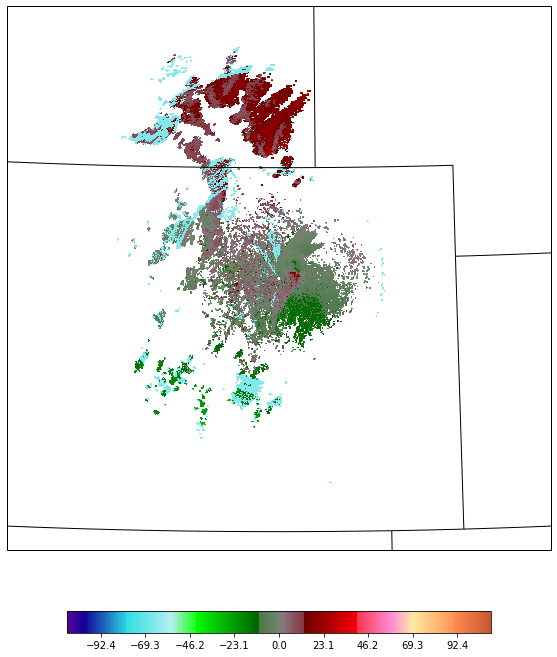

In [19]:
Map("KFTG",2019,5,27,19,35)

In [ ]:
for i in range(0,12):
    Map("KFTG",2019,5,26,19,i*5)